In [2]:
import os
try: # Check platform (Colab or Jupyter)
    from google.colab import drive
    drive.mount('/content/drive')
    PATH = "/content/drive/My Drive/joklar/"
except:
    PATH = os.getcwd() + "/"

In [3]:
import numpy as np, os, sys, time, pandas as pd, tensorflow as tf, random
start_time = time.time()
import keras
from tensorflow.keras.optimizers.legacy import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
sys.path.append(PATH + "src")
from util.util import install_import
from util.image_util import get_border_indices
from osgeo import gdal

In [4]:
# Define model type and data to use
MODELTYPE = "unet"
AUGMENTATION = False
MODEL_PATH = PATH + "results/" + MODELTYPE + "/"
DATA_PATH = PATH + "data/lang/"
os.makedirs(MODEL_PATH, exist_ok=True)
os.chdir(MODEL_PATH)

In [6]:
# Import project-specific packages

# NOTES
# deeplab-v3+ is copied more or less directly from the github repository
#    github.com/david8862/tf-keras-deeplabv3p-model-set
# (the original files are in the subdirectory from_github, cf differences.txt)
#
# unet is copied from...

if MODELTYPE == "unet":
    from models.unet import get_unet
else: # deeplab
    install_import("keras_applications")
    from models.deeplabv3p import model

In [8]:
def create_model():
    if MODELTYPE == "unet":
      input_img = keras.layers.Input((256, 256, 13), name='img')
      Adam_params = {"learning_rate":1e-4, "clipnorm":1.0}
      model = get_unet(input_img, n_filters=64, dropout=0.2, batchnorm=True)

    else: # deeplab
      Adam_params = {"learning_rate":1e-4}
      get_deeplab = model.get_deeplabv3p_model
      model = get_deeplab(model_type='resnet50', num_classes=1,
                          model_input_shape=(256,256),
                          output_stride=16,
                          freeze_level=0,
                          weights_path=None,
                          training=True,
                          use_subpixel=False)

    model.compile(optimizer = Adam(**Adam_params),
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    model.save('model_first.keras')
    return model
    # NOTE: Saving weights only gives a file just as big as saving the whole model

In [9]:
def define_callbacks():
    if MODELTYPE == "unet":
      early_stopping = EarlyStopping(patience=15, verbose=1)
      reduce_LR_on_plateau = ReduceLROnPlateau(factor=0.1,
                                              patience=7,
                                              min_lr=0.00001,
                                              verbose=1),

    else: # deeplab
      early_stopping = EarlyStopping(min_delta=0.01,
                                    patience=40,
                                    verbose=1,
                                    monitor='val_loss',
                                    restore_best_weights=True)
      reduce_LR_on_plateau = ReduceLROnPlateau(factor=0.1,
                                              patience=10,
                                              min_lr=1e-12,
                                              verbose=1)
    checkpoint_best = ModelCheckpoint('model_best.keras',
                                      verbose=1,
                                      monitor="val_loss",
                                      save_weights_only=True,
                                      save_best_only=True)
    checkpoint_last = ModelCheckpoint('model_last.keras',
                                      save_weights_only=True)
    callbacks = [
      EarlyStopping(patience=60, verbose=1),
      ReduceLROnPlateau(factor=0.3, patience=10, min_lr=0.00001, verbose=1),
      checkpoint_best,
      checkpoint_last,
    ]
    return callbacks

In [10]:
def train_val_test_split(border_indices):
  # Define data split (training, validation, and test sets)
  seed = 42
  tf_seed = 42
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(tf_seed)
  test_size = 0.15
  train_size = 0.18  # or 0.15/(1 - test_size)
  temp, test = train_test_split(border_indices, test_size = test_size, random_state=seed)
  train, val = train_test_split(temp, test_size = train_size, random_state=seed)
  return train, val, test

In [11]:
def albumentations_generator(img, mask, train):
  # Implement data augmentation with the albumentations package
  augmentation = {
      "random_gamma_probability": 0.5,
      "random_gamma_gamma_limit": [80, 120],
      "flipud_probability": 0.5,
      "fliplr_probability": 0.5,
      "rotate90_probability": 0.5,
      "random_crop_probability": 0.5,
      "random_crop_height": 256,
      "random_crop_width": 256,
      "random_crop_scale_x": 0.5,
      "random_crop_scale_y": 0.5
  }
  from util.generator import AugmentDataGenerator
  train_gen = AugmentDataGenerator(img[train], mask[train], augmentation)
  return train_gen

In [13]:
%%time
(image, mask) = load_data("border")
dtype = image.dtype
ntile = len(image)
nchan = image.shape[-1]
print(f"{nchan} channels, {ntile} tiles, datatype: {dtype}")

13 channels, 105 tiles, datatype: float64
CPU times: user 2.52 s, sys: 381 ms, total: 2.9 s
Wall time: 10.5 s


In [13]:
(train, val, test) = train_val_test_split(range(ntile))
if AUGMENTATION:
  data_input = (albumentations_generator(image, mask, train),)
else:
  data_input = (image[train], mask[train])
model = create_model()
callbacks = define_callbacks()

In [14]:
# Train (save best results, and possibly all)
do_train = True
model = tf.keras.models.load_model('model_first.keras')
if do_train:
  results = model.fit(*data_input,
                      batch_size = 8 if model=="deeplab" else 8,
                      epochs = 60,
                      callbacks = callbacks,
                      validation_data=(image[val], mask[val]))
  history = results.history
else:
  model = tf.keras.models.load_model('model_best.h5')
  history = pd.read_csv('result_history.csv')

Epoch 1/60
9/9 [==============================] - ETA: 0s - loss: 0.6245 - accuracy: 0.6054
Epoch 1: val_loss improved from inf to 0.60225, saving model to model_best.keras
9/9 [==============================] - 27s 2s/step - loss: 0.6245 - accuracy: 0.6054 - val_loss: 0.6023 - val_accuracy: 0.4582 - lr: 1.0000e-04
Epoch 2/60
9/9 [==============================] - ETA: 0s - loss: 0.2843 - accuracy: 0.9349
Epoch 2: val_loss did not improve from 0.60225
9/9 [==============================] - 2s 199ms/step - loss: 0.2843 - accuracy: 0.9349 - val_loss: 1.2141 - val_accuracy: 0.4583 - lr: 1.0000e-04
Epoch 3/60
9/9 [==============================] - ETA: 0s - loss: 0.1935 - accuracy: 0.9524
Epoch 3: val_loss did not improve from 0.60225
9/9 [==============================] - 2s 191ms/step - loss: 0.1935 - accuracy: 0.9524 - val_loss: 2.5420 - val_accuracy: 0.4582 - lr: 1.0000e-04
Epoch 4/60
9/9 [==============================] - ETA: 0s - loss: 0.1407 - accuracy: 0.9650
Epoch 4: val_loss did

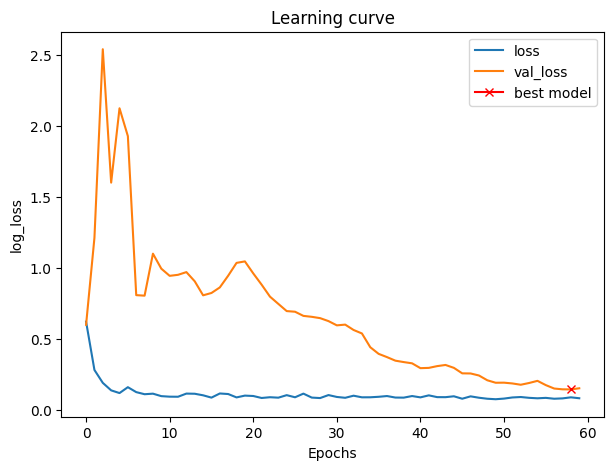

In [15]:
# Plot learning curve
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 5))
plt.title("Learning curve")
plt.plot(history["loss"], label="loss")
plt.plot(history["val_loss"], label="val_loss")
plt.plot(np.argmin(history["val_loss"]),
        np.min(history["val_loss"]),
        marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

1/1 [==============================] - 3s 3s/step - loss: 0.1552 - accuracy: 0.9782
Accuracy on test: 0.9782314300537109


(array([ 644134., 2129999.,  390702.,  161726.,  131756.,   73243.,
          44713.,   48417.,   90351., 3166239.]),
 array([0.0364091 , 0.1327654 , 0.22912169, 0.32547796, 0.42183426,
        0.51819056, 0.61454684, 0.71090311, 0.80725938, 0.90361571,
        0.99997199]),
 <BarContainer object of 10 artists>)

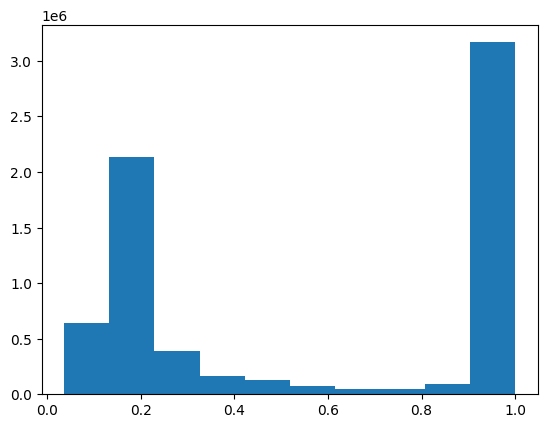

In [16]:
# Compute predicted probabilites everywhere; evaluate on test
probs = model.predict(image, verbose=1)
(test_loss, test_accuracy) = model.evaluate(image[test], mask[test])
print(f'Accuracy on test: {test_accuracy}')
plt.hist(probs.ravel())

In [17]:
# Save the training history and model predictions
pdhistory = pd.DataFrame(history)
pdhistory.to_csv("result_history.csv")
np.savez("probs.npz", probs, test_loss, test_accuracy)

In [18]:
# Display running time and disconnect
end_time = time.time()
min, sec = divmod(int(end_time - start_time), 60)
print(f"Total execution time: {min}:{sec:02}")

Total execution time: 3:20


In [ ]:
from google.colab import runtime
runtime.unassign()